In [0]:
from pathlib import Path
import pandas as pd
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import spacy
import string
import re
from spacy.symbols import ORTH
from collections import Counter

%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as tt
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

In Image captioning, we generate text from an image. We feed the output of a CNN through a linear layer to an RNN. Let's start by downloading the data.

In [3]:
!mkdir coco
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./coco/ 
!wget http://images.cocodataset.org/zips/train2014.zip -P ./coco/ 
!wget http://images.cocodataset.org/zips/val2014.zip -P ./coco/

mkdir: cannot create directory ‘coco’: File exists
--2020-05-11 21:07:59--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 52.176.224.96
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|52.176.224.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19673183 (19M) [application/octet-stream Charset=UTF-8]
Saving to: ‘./coco/captions_train-val2014.zip’

captions_train-val2 100%[===================>]  18.76M  17.5MB/s    in 1.1s    

2020-05-11 21:08:01 (17.5 MB/s) - ‘./coco/captions_train-val2014.zip’ saved [19673183/19673183]

--2020-05-11 21:08:02--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.224.56
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.224.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1351057371

In [0]:
from pycocotools.coco import COCO
import json
from PIL import Image

In [0]:
path = Path("coco")
train_ann = path/"annotations/captions_train2014.json"
val_ann = path/"annotations/captions_val2014.json"

In [6]:
# !ls coco 

annotations		    train2014	   val2014
captions_train-val2014.zip  train2014.zip  val2014.zip


In [0]:
from zipfile import ZipFile
for f in ['captions_train-val2014.zip', 'train2014.zip', 'val2014.zip']:
    with ZipFile(path/f, 'r') as archive:
        archive.extractall(path)

In [0]:
!rm -rf coco/captions_train-val2014.zip coco/train2014.zip coco/val2014.zip

In [9]:
# !ls coco/annotations/

captions_train2014.json  captions_val2014.json


In [10]:
coco=COCO(train_ann)
coco

loading annotations into memory...
Done (t=3.61s)
creating index...
index created!


In [11]:
train_ids = coco.getImgIds()
train_ids[:10]

[57870, 384029, 222016, 520950, 69675, 547471, 122688, 392136, 398494, 90570]

In [12]:
img_id = train_ids[0]
annIds = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(annIds)
print(train_ids[0])
anns

57870


[{'caption': 'A restaurant has modern wooden tables and chairs.',
  'id': 787980,
  'image_id': 57870},
 {'caption': 'A long restaurant table with rattan rounded back chairs.',
  'id': 789366,
  'image_id': 57870},
 {'caption': 'a long table with a plant on top of it surrounded with wooden chairs ',
  'id': 789888,
  'image_id': 57870},
 {'caption': 'A long table with a flower arrangement in the middle for meetings',
  'id': 791316,
  'image_id': 57870},
 {'caption': 'A table is adorned with wooden chairs with blue accents.',
  'id': 794853,
  'image_id': 57870}]

In [13]:
file = coco.loadImgs(img_id)[0]['file_name']
file

'COCO_train2014_000000057870.jpg'

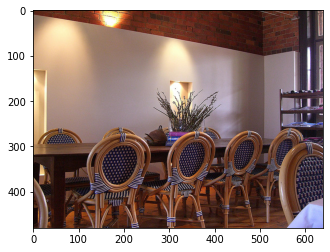

In [14]:
p = path/"train2014"/file
im = Image.open(p)
plt.imshow(im);

In [20]:
im.size, im.mode

((640, 480), 'RGB')

## Data Augmentation

In [0]:
crop = tt.CenterCrop(256)
rcrop = tt.RandomCrop(256)
rot = tt.RandomRotation(10)
flip = tt.RandomHorizontalFlip(p=1)
# tt.RandomRotation?

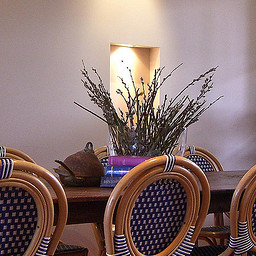

In [18]:
# center crop
crop(im)

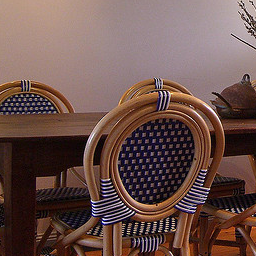

In [23]:
# random crop
rcrop(im)

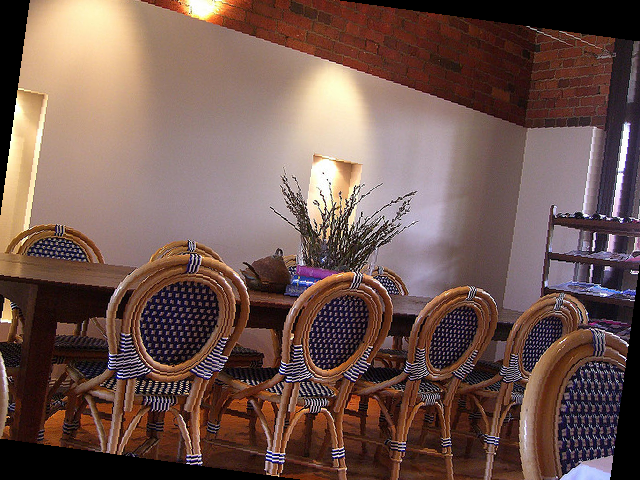

In [26]:
# random rotation: -10 to 10
rot(im)

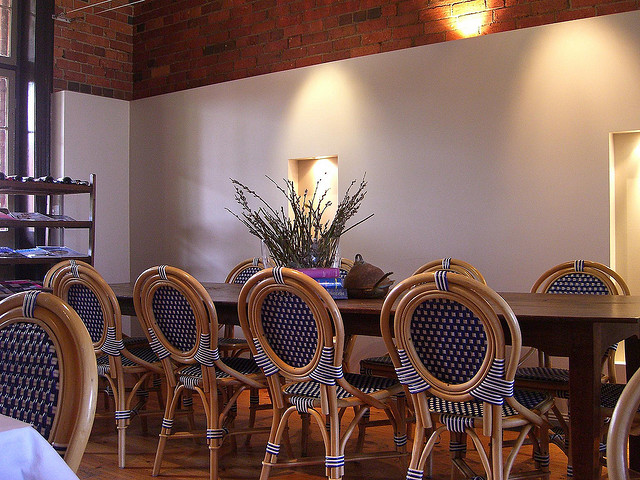

In [28]:
flip(im)

## Building a vocabulary

In [0]:
import pickle

In [34]:
# run once
# !python3 -m spacy download en
# !pip install transformers

     |████████████████████████████████| 645kB 2.6MB/s 
     |████████████████████████████████| 3.8MB 37.2MB/s 
     |████████████████████████████████| 890kB 37.2MB/s 
     |████████████████████████████████| 1.0MB 32.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f00c64ade354a8ef36fba17e00f98562761f630ae7ea4115b82bf2f284cdc54d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [35]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [0]:
my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(x)]

In [0]:
def tokenize(x): return tokenizer.encode(x)

In [37]:
coco = COCO(path/"annotations/captions_train2014.json")
annIds = list(coco.anns.keys())
caption = coco.anns[annIds[0]]['caption']
# spacy_tok(caption.lower())
tokenize(caption.lower())

loading annotations into memory...
Done (t=1.22s)
creating index...


Using pad_token, but it is not set yet.


index created!


[64, 845, 3424, 290, 880, 24789, 6565, 12436]

In [38]:
caption.lower(), tokenize(caption.lower()), tokenizer.decode(tokenize(caption.lower()))

Using pad_token, but it is not set yet.
Using pad_token, but it is not set yet.


('a very clean and well decorated empty bathroom',
 [64, 845, 3424, 290, 880, 24789, 6565, 12436],
 'a very clean and well decorated empty bathroom')

Reference: https://github.com/yanneta/pytorch-tutorials/blob/master/image-caption-tutorial.ipynb